In [38]:
print("Hello world")

Hello world


In [39]:
import numpy as np 
from PIL import Image
%matplotlib inline 
#to use as command line calls #using inline graphs will come next to code
import matplotlib.pyplot as plt #for graphs
import os #for operating system dependent fucntionality
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras import layers, Model, Sequential
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from keras import callbacks #for training logs, saving to disk periodically
import cv2 #OpenCV(Open Source computer vision lib), containg CV algos
import string
from keras import metrics

In [40]:
#os.listdir("/kaggle/input/dataset2/new_captcha")
n = len(os.listdir("/kaggle/input/dataset9/captcha"))
print(f"Total images: {n}")


Total images: 1756


In [41]:
imgshape=(50,180,1) #50-height, 200-width, 1-no of channels

In [42]:
character= string.ascii_uppercase + "0123456789" # All symbols captcha can contain
nchar = len(character) #total number of char possible
nchar

36

In [43]:
#preprocesss image
def preprocess():
  X = np.zeros((n,50,180,1)) #1070*50*200 array with all entries 0
  y = np.zeros((5,n,nchar)) #5*1070*36(5 letters in captcha) with all entries 0

  for i, pic in enumerate(os.listdir("/kaggle/input/dataset9/captcha")):
  #i represents index no. of image in directory 
  #pic contains the file name of the particular image to be preprocessed at a time
    
    image_array = cv2.imread(os.path.join("/kaggle/input/dataset9/captcha", pic), cv2.IMREAD_GRAYSCALE) #Read image in grayscale format
    _, binary_image = cv2.threshold(image_array, 150, 255, cv2.THRESH_BINARY)
    img = Image.fromarray(binary_image)
    img = cv2.medianBlur(np.array(img), 3)  
    img = cv2.medianBlur(np.array(img), 3)
    pic_target = pic[:-4]#this drops the .png extension from file name and contains only the captcha for training
    
    if len(pic_target) == 5: #captcha is of 5 letters
      img = img / 255.0 #scales the image between 0 and 1
      img = np.reshape(img, (50, 180, 1)) #reshapes image to width 200 , height 50 ,channel 1 

      target=np.zeros((5,nchar)) #creates an array of size 5*36 with all entries 0

      for j, k in enumerate(pic_target):
      #j iterates from 0 to 4(5 letters in captcha)
      #k denotes the letter in captcha which is to be scanned
         index = character.find(k) #index stores the position of letter k of captcha in the character string
         target[j, index] = 1 #replaces 0 with 1 in the target array at the position of the letter in captcha

      X[i] = img #stores all the images
      y[:,i] = target #stores all the info about the letters in captcha of all images

  return X,y

In [44]:
X, y = preprocess()

In [45]:
X_train, y_train = X[:1600], y[:, :1600]
X_test, y_test = X[1600:], y[:, 1600:]

In [46]:
#create model
def createmodel():
    img = layers.Input(shape=imgshape) # Get image as an input of size 50,200,1
    conv1 = layers.Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu')(img) #50*200
    mp1 = layers.MaxPooling2D((2,2),padding='same')(conv1)  # 25*100
    conv2 = layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(mp1)
    mp2 = layers.MaxPooling2D((2,2),padding='same')(conv2)  # 13*50
    conv3 = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(mp2)
    bn = layers.BatchNormalization()(conv3) #to improve the stability of model
    mp3 = layers.MaxPooling2D(padding='same')(bn)  # 7*25
    
    flat = layers.Flatten()(mp3) #convert the layer into 1-D
    
    outs = []
    for _ in range(5): #for 5 letters of captcha
        dens1 = layers.Dense(128, activation='sigmoid')(flat)
        drop1 = layers.Dropout(0.5)(dens1) #drops 0.5 fraction of nodes
        dens2 = layers.Dense(64, activation='sigmoid')(drop1)
        drop2 = layers.Dropout(0.5)(dens2) #drops 0.5 fraction of nodes
        res = layers.Dense(nchar, activation='softmax')(drop2)

        outs.append(res) #result of layers
    
    # Compile model and return it
    model = Model(img, outs) #create model
    return model

In [47]:
#Create model
model=createmodel();
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy', 'accuracy', 'accuracy', 'accuracy', 'accuracy'])
model.summary();

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50, 180,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 50, 180,   │        160 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 25, 90,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 25, 90,    │      4,640 │ max_pooling2d_12… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 13, 45,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 13, 45,    │     18,496 │ max_pooling2d_13… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 13, 45,    │        256 │ conv2d_14[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 7, 23, 64) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 10304)     │          0 │ max_pooling2d_14… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 128)       │  1,319,040 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_63 (Dense)    │ (None, 128)       │  1,319,040 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 128)       │  1,319,040 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_69 (Dense)    │ (None, 128)       │  1,319,040 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 128)       │  1,319,040 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 128)       │          0 │ dense_60[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 128)       │          0 │ dense_63[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_44          │ (None, 128)       │          0 │ dense_66[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_46          │ (None, 128)       │          0 │ dense_69[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_48          │ (None, 128)       │          0 │ dense_72[0][0]  

 Total params: 6,671,732 (25.45 MB)

 Trainable params: 6,671,604 (25.45 MB)

 Non-trainable params: 128 (512.00 B)

In [48]:
early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=10,          # Number of epochs to wait before stopping
                               restore_best_weights=True)  # Restore the best weights during training


In [49]:
try:
    hist = model.fit(
        X_train,
        [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]],
        batch_size=16,  # Consider trying a smaller batch size, like 16
        epochs=100,
        callbacks=[early_stopping],
        validation_split=0.15,  # Try 0 if you suspect validation split issues
        verbose=1  # Set to 2 to get more detailed logs
    )
except Exception as e:
    print(f"Error during training: {e}")

#batch size- 32 defines no. of samples per gradient update
#Validation split=0.2 splits the training set in 80-20% for training nd testing

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - dense_62_accuracy: 0.0200 - dense_65_accuracy: 0.0249 - dense_68_accuracy: 0.0266 - dense_71_accuracy: 0.0287 - dense_74_accuracy: 0.0275 - loss: 18.9475 - val_dense_62_accuracy: 0.0292 - val_dense_65_accuracy: 0.0208 - val_dense_68_accuracy: 0.0208 - val_dense_71_accuracy: 0.0333 - val_dense_74_accuracy: 0.0167 - val_loss: 17.9719
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_62_accuracy: 0.0275 - dense_65_accuracy: 0.0336 - dense_68_accuracy: 0.0248 - dense_71_accuracy: 0.0402 - dense_74_accuracy: 0.0320 - loss: 18.2266 - val_dense_62_accuracy: 0.0292 - val_dense_65_accuracy: 0.0333 - val_dense_68_accuracy: 0.0208 - val_dense_71_accuracy: 0.0583 - val_dense_74_accuracy: 0.0417 - val_loss: 17.9506
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - dense_62_accuracy: 0.0392 - dense_65_accuracy: 0.0406 - dense_68_accuracy: 0.0452 - dense_71_accuracy: 0.0485 - dense_74_accuracy: 0.0395 - loss: 17.8533 - val_dense_62_ac

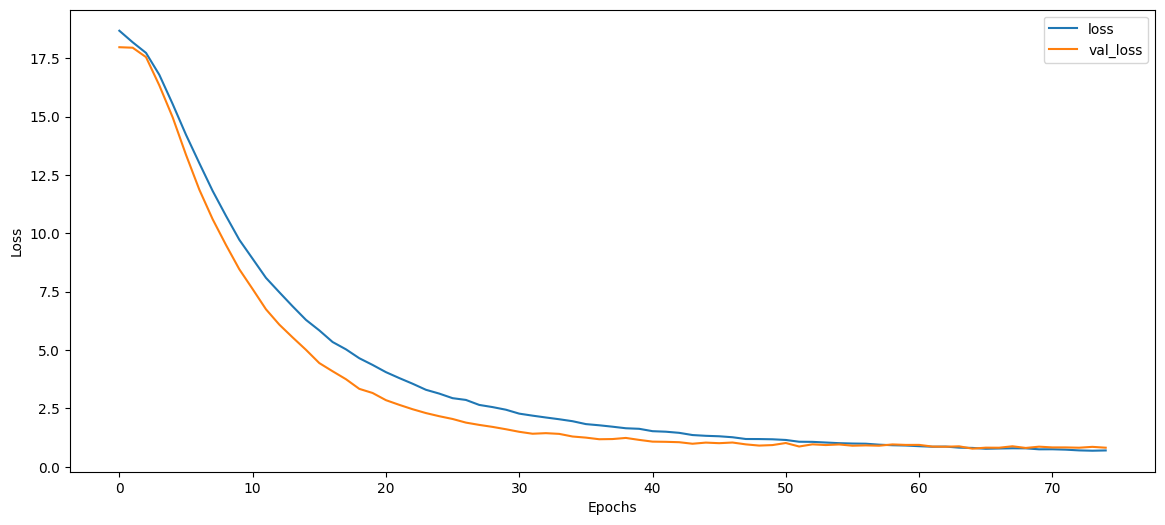

In [63]:
#graph of loss vs epochs
plt.figure(figsize=(14,6))
for label in ["loss", "val_loss"]:
  plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig("/kaggle/working/loss2.png", dpi=200, format='png')
plt.show()


In [ ]:
#Loss on training set
#Finding Loss on training set
preds = model.evaluate(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]])
print ("Loss on training set= ", (preds[0]))

In [ ]:
#Finding loss on test set
preds = model.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])
print ("Loss on testing set= " , (preds[0]))

In [53]:
#to predict captcha
def predict(filepath):
    image_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    _, binary_image = cv2.threshold(image_array, 150, 255, cv2.THRESH_BINARY)
    img = Image.fromarray(binary_image)
    img = cv2.medianBlur(np.array(img), 3)  
    img = cv2.medianBlur(np.array(img), 3)
    if img is not None: #image foud at file path
        img = cv2.resize(img, (180, 50))
        # Add the channel dimension
        img = np.expand_dims(img, axis=-1)
        img = img / 255.0 #Scale image
    else:
        print("Not detected");

    res = np.array(model.predict(img[None, :, :, :])) #np.newaxis=1 
    #added this bcoz x_train 970*50*200*1
    #returns array of size 1*5*36 
    result = np.reshape(res, (5, 36)) #reshape the array
    k_ind = []
    probs = []
    for i in result:
        k_ind.append(np.argmax(i)) #adds the index of the char found in captcha

    capt = '' #string to store predicted captcha
    for k in k_ind:
        capt += character[k] #finds the char corresponding to the index
    return capt 

In [54]:
print("Predicted Captcha =",predict('/kaggle/input/dataset9/captcha/PA18E.jpg'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
Predicted Captcha = PA18E


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━

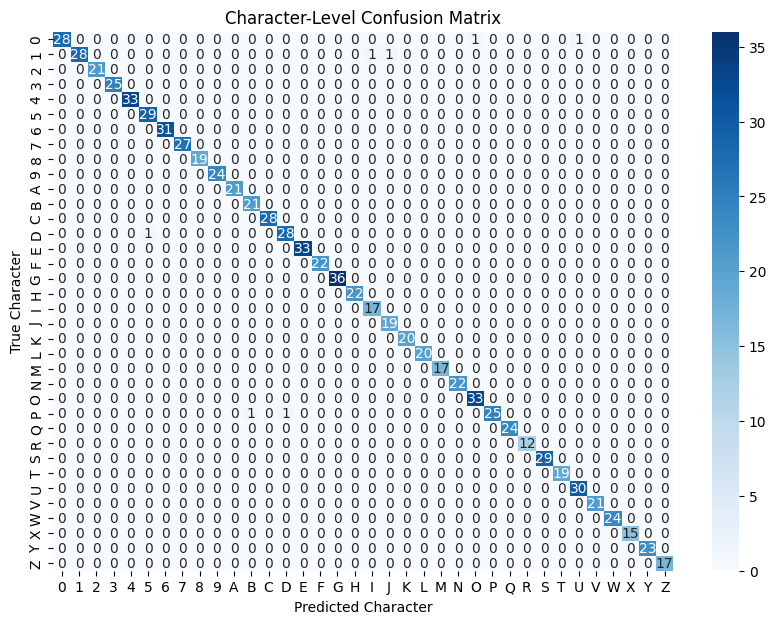

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       1.00      0.93      0.97        30
           2       1.00      1.00      1.00        21
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        33
           5       0.97      1.00      0.98        29
           6       1.00      1.00      1.00        31
           7       1.00      1.00      1.00        27
           8       1.00      1.00      1.00        19
           9       1.00      1.00      1.00        24
           A       1.00      1.00      1.00        21
           B       0.95      1.00      0.98        21
           C       1.00      1.00      1.00        28
           D       0.97      0.97      0.97        29
           E       1.00      1.00      1.00        33
           F       1.00      1.00      1.00        22
           G       1.00      1.00      1.00        36
           H       1.00    

In [55]:
# Parameters
image_folder = '/kaggle/input/confusion-matrix/confusion matrix'  # Change this to your folder path in Kaggle
class_names = list('0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ')  # Adjust based on your CAPTCHA classes

# Step 1: Load Images and True Labels
true_labels = []
predicted_labels = []

for filename in os.listdir(image_folder):
    if filename.endswith('.png') or filename.endswith('.jpg'):  # Change as needed
        # Extract true label from filename (remove extension)
        true_label = filename.split('.')[0]
        true_labels.append(true_label)

        # Get the predicted label using your function
        img_path = os.path.join(image_folder, filename)
        predicted_label = predict(img_path)  # Call your prediction function
        predicted_labels.append(predicted_label)

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Step 2: Flatten True and Predicted Labels
all_true_chars = []
all_predicted_chars = []

for true, pred in zip(true_labels, predicted_labels):
    all_true_chars.extend(list(true))  # Add each character of the true label
    all_predicted_chars.extend(list(pred))  # Add each character of the predicted label

# Convert to numpy arrays
all_true_chars = np.array(all_true_chars)
all_predicted_chars = np.array(all_predicted_chars)

# Step 3: Create Character-Level Confusion Matrix
cm = confusion_matrix(all_true_chars, all_predicted_chars, labels=class_names)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Character')
plt.ylabel('True Character')
plt.title('Character-Level Confusion Matrix')
plt.show()

# Additional classification report
report = classification_report(all_true_chars, all_predicted_chars, target_names=class_names)
print(report)


In [56]:
model.save('alphanumeric_captcha_recognition_model.h5')
